In [939]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
import os
import pandas as pd
import librosa as lb
from librosa import display
import scipy
from torch import nn

In [2]:
"""
Attribute Information:

Description of raw_data _*** file 
Each file consist of 10 columns: 
1) Time - time in ms; 
2-9) Channel - eightEMG channels of MYO Thalmic bracelet; 
10) Class â€“thelabel of gestures: 
0 - unmarked data, 
1 - hand at rest, 
2 - hand clenched in a fist, 
3 - wrist flexion, 
4 - wrist extension, 
5 - radial deviations, 
6 - ulnar deviations, 
7 - extended palm (the gesture was not performed by all subjects).
"""

'\nAttribute Information:\n\nDescription of raw_data _*** file \nEach file consist of 10 columns: \n1) Time - time in ms; \n2-9) Channel - eightEMG channels of MYO Thalmic bracelet; \n10) Class â€“thelabel of gestures: \n0 - unmarked data, \n1 - hand at rest, \n2 - hand clenched in a fist, \n3 - wrist flexion, \n4 â€“ wrist extension, \n5 â€“ radial deviations, \n6 - ulnar deviations, \n7 - extended palm (the gesture was not performed by all subjects).\n'

In [464]:
def load_random_sample(path):
    """load a random sample from the dataset
    
    Arguments:
    
    path : string, path to the dataset
    
    """
    infos = next(os.walk(path + '/'))
    root = infos[0]
    folders = infos[1]
    index = np.random.randint(0,len(folders)-1)
    files = os.listdir(os.path.join(root , folders[index]))
    index2 = np.random.randint(0,len(files)-1)
    data = pd.read_csv(os.path.join(root , folders[index] , files[index2]), sep='\t')
    data.columns = ['time', 'channel_1','channel_2','channel_3',
                    'channel_4','channel_5','channel_6','channel_7', 'channel_8', 'labels']
    
    return data
    
    

In [465]:
def load_sample(path):
    """load a specific sample from the raw dataset
    
    Arguments:
    
    path : string, path to the sample in the raw dataset
    
    """
    
    data = pd.read_csv(path, sep='\t')
    data.columns = ['time', 'channel_1','channel_2','channel_3',
                    'channel_4','channel_5','channel_6','channel_7', 'channel_8', 'labels']
    
    return data
    
    

In [535]:
path = '/Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/EMG_data_for_gestures-master'

In [399]:
def plot_sample(data, channels):
    """Plots the selected channels of the sample data
    
    Arguments:
    
    data : DataFrame, a single sample in the dataset
    channels : list, a list of integers between 0 and 7
    
    """
    
    time = data['time']
    n = len(channels)
    for i in channels:
        plt.subplot(str(n) + '1' + str(i))
        plt.plot(time, data['channel_' + str(i)], 'k', alpha = 0.75)
    for j in range(1,8):
        try:
            for k in channels:
                plt.subplot(str(n) + '1' + str(k))
                inds = np.hstack(np.where(data['labels'] == j)[0])
                plt.plot(time[inds], data['channel_' + str(k)][inds],'o' ,alpha = 0.15)  
        except:
            pass
            
    #plt.tight_layout()
    plt.show()

    


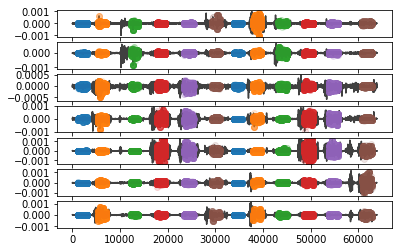

no label = 7


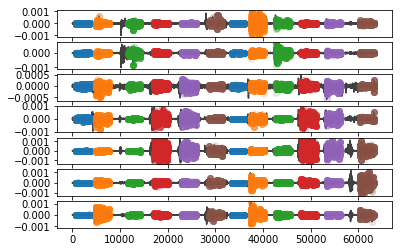

In [467]:
# test for plot_sample and extend_labeled_regions
sample = load_random_sample(path)
plot_sample(sample,list(([1,2,3,4,5,6,7])))
plt.figure()
sample = extend_labeled_region(sample)
plot_sample(sample,list(([1,2,3,4,5,6,7])))


In [635]:
def extend_labeled_region(sample, insertL = 500):
    """Extend a labeled region of the EGM data
    
    Arguments:
    
    sample    : pandas dataframe representating a sample loaded with load_sample() or load_random_sample()
    insertL : int, magnitude of the extension on each side of the region
    """
    labels = set(sample['labels'])
    
    for j in list(labels)[1:]:
        try:
            inds = np.hstack(np.where(sample['labels'] == j)[0])
            inds = np.insert(inds,0,np.arange(inds[0]-insertL, inds[0]))
            jumps = np.hstack(np.where(np.diff(inds) > 2)[0])
            for jump in jumps:
                refLow = inds[jump-1]
                refHigh = inds[jump+1]
                #insert at the end of the first region
                inds = np.insert(inds, jump-1, np.arange(inds[jump-1], inds[jump-1] + insertL))
                #insert at the beginning of the second region
                inds = np.insert(inds, jump+1 + insertL, np.arange(inds[jump+1+insertL] - insertL, inds[jump+1+insertL]))
                #insert at the end of the second region
                inds = np.insert(inds, len(inds), np.arange(inds[-1] , inds[-1] + insertL))  
            sample['labels'].values[inds] = j
        except:
            print(f'no label = {j}')

    return sample




In [710]:
def create_single_txt_sample(file,index):
    """Loads raw data and splits it into labeled regions creating a sample
    
    Arguments:
    
    file    : string, path to the raw data txt
    index   : int, number of the raw data file used for naming
    """    
    save_root = '/Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/txts'
    sample = load_sample(file)
    sample = extend_labeled_region(sample)
    
    for label in list(set(sample['labels']))[1:]:
        try:
            inds = np.hstack(np.where(sample['labels'] == label)[0])
        except:
            print('bad sample')
            return False
            
            
        jumps = np.hstack(np.where(np.diff(inds) > 2)[0])
        for channel in range(1,9):
            key = 'channel_' + str(channel)
            #isolate first repeat of gesture
            data1 = sample[key][inds[:jumps[0]]]
            #isolate second repeat of gesture
            data2 = sample[key][inds[jumps[0]+1:len(inds)]]
            #clip the lenght at 2500 and if shorter pad with zeros
            try:
                data1 = data1[:2500]
            except:
                data1 = np.pad(data1,(0,2500-len(data1)))
                print('shortdata')
            try:
                data2 = data2[:2500]
            except:
                data2 = np.pad(data2,(0,2500-len(data2)))
                print('shortdata')
            #save each repeat in the labeled folder in the database
            np.savetxt(os.path.join(save_root,str(int(label)),''.join([key,'_',str(index).zfill(3),'.txt'])), data1)
            np.savetxt(os.path.join(save_root,str(int(label)),''.join([key,'_',str(index+1).zfill(3),'.txt'])), data2)
    return True


In [802]:
#get all the txt files in the raw data
files = [y for x in os.walk(path) for y in glob.glob(os.path.join(x[0], '*.txt'))]

In [713]:
def create_dataset_dirs(path):
    """create empty dirs corresponding to the labels

    Arguments: 
        path : string, path where to create dirs corresponding to labels

    """
    for i in range(1,8):
        os.mkdir(os.path.join(path, str(i)))

In [706]:
# runs over all files and saves each processed sample to create the custom dataset
k = 1
for file in files[1:]:
    res = create_single_txt_sample(file,k)
    if res:
        k = k+2

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
no label = nan
bad sample
False
True
True
True
True
True


In [759]:
# creates the folders for the formatted dataset
create_dataset_dirs(processed_ds_path)
glob.glob(os.path.join(processed_ds_path,'*'))

['/Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/1',
 '/Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/2',
 '/Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/3',
 '/Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/4',
 '/Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/5',
 '/Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/6',
 '/Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/7']

In [778]:
raw_ds_path = '/Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/txts'
processed_ds_path = '/Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed'
def process_data_set(raw_ds_path, processed_ds_path):
    """stacks each 8 channel and label for each smaple into a tuple. the tuple has a (8,2500) data array and (1) label 

    Arguments:
        raw_ds_path : 
        processed_ds_path :

    """
    try:
        create_dataset_dirs(processed_ds_path)
    except:
        print('WARNING: directories corresponding to labels 1-7 already exist')
    
    folders = np.sort(glob.glob(os.path.join(raw_ds_path,'*')))
    labels = np.sort([x for x in os.listdir(raw_ds_path) if len(x)<2])
    savefolders = np.sort((glob.glob(os.path.join(processed_ds_path,'*'))))
    
     
    for folder, savefolder, label in zip(folders, savefolders, labels):
        files = glob.glob(os.path.join(folder,'*'))
        Nfiles = len(files)/8
        if Nfiles%int(Nfiles) != 0:
            print('WARNING: dat least one sample has not exactly 8 channels')
        for i in range(1,int(Nfiles)):
            index = str(i).zfill(3)
            batch = glob.glob(os.path.join(folder,'*' + str(index).zfill(3) +'.txt'))
            datalist = [np.loadtxt(file) for file in batch]
            data = np.array(datalist)
            np.save(os.path.join(savefolder, label + '_' + index + '.npy'), data)
        print(f'saving formatted data in {savefolder}')
            
process_data_set(raw_ds_path, processed_ds_path)             
            

saving formatted data in /Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/1
saving formatted data in /Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/2
saving formatted data in /Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/3
saving formatted data in /Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/4
saving formatted data in /Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/5
saving formatted data in /Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/6
saving formatted data in /Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset/processed/7


In [1432]:
# our custom Dataset class
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class DatasetMYO(Dataset):
    
    def __init__(self,datapath,transform,sample_len=2500):
        self.sample_len = sample_len
        self.path = datapath
        self.files = [y for x in os.walk(self.path) 
                        for y in glob.glob(os.path.join(x[0], '*.npy'))]
        self.len = len(self.files)
        self.transform = transform
        
    def __getitem__(self, index):
        sample = np.load(self.files[index])
        label = int(self.files[index].split('_')[-2][-1])
        if len(sample) < 2500:
            #pad with zeros if the length is smaller than 2500
            sample = np.array([np.pad(channel,(0,self.sample_len - len(channel)),'constant') for channel in sample])
            sample = sample - np.mean(sample, axis=1).reshape(8,1)
            sample = sample / np.std(sample, axis=1).reshape(8,1)
            label = torch.LongTensor([label])[0]
            
        return(sample, label)
        
    
    def __len__(self):
        return self.len
    
#convert th einput to tnesor for torchvision handling
class ToTensor_(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        return torch.from_numpy(data).float()

In [1362]:
sample0, label = next(iter(dl))

In [1363]:
# create network architecture
import torch.nn.functional as F

class ClassifierMYO(nn.Module):
    
    def __init__(self):
        
        super(ClassifierMYO, self).__init__()
        self.conv1 = nn.Conv1d(8,16,55,padding = 24)
        self.conv2 = nn.Conv1d(16,32,25,padding = 12)
        self.pool = nn.MaxPool1d(2, 2)
        # linear layer (32 * 2500/2/2  -> 500)
        self.fc1 = nn.Linear(32*623, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        # flatten image input

        x = x.view(15,32*623)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [1425]:
model = ClassifierMYO()
model.double()
dl = DataLoader(DSMYO, batch_size = 15, shuffle=True)
#sample1 = model.forward(sample0)

In [1430]:
len(train_loader.dataset)

846

In [1431]:
dl

In [1433]:
# train script without validation
import torch.optim as optim

DSMYO = DatasetMYO(processed_ds_path, transform)
model = ClassifierMYO()
model.double()
dl = DataLoader(DSMYO, batch_size = 15, shuffle=True)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 10

for e in range(epochs):
    train_loss = 0.0
    model.train()
    status = 0
    for sample, label in dl:
        status += 1
        if status%10 == 0:
            print(f'epoch progress: {int (status*15/len(dl.dataset)*100)}%')
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        try:
            output = model(sample)
            # calculate the batch loss
            loss = criterion(output, label)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*sample.size(0)
        except:
            print(f'error when computing the output. smaple.shape = {sample.shape}')

        
    # calculate average losses
    train_loss = train_loss/len(dl.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} '.format(
        e, train_loss))

epoch progress: 17%
epoch progress: 35%
epoch progress: 53%
epoch progress: 70%
epoch progress: 88%
error when computing the output. smaple.shape = torch.Size([6, 8, 2500])
Epoch: 0 	Training Loss: 13.212522 
epoch progress: 17%
epoch progress: 35%
epoch progress: 53%
epoch progress: 70%
epoch progress: 88%
error when computing the output. smaple.shape = torch.Size([6, 8, 2500])
Epoch: 1 	Training Loss: 1.792178 
epoch progress: 17%
epoch progress: 35%
epoch progress: 53%
epoch progress: 70%
epoch progress: 88%
error when computing the output. smaple.shape = torch.Size([6, 8, 2500])
Epoch: 2 	Training Loss: 1.721033 
epoch progress: 17%
epoch progress: 35%
epoch progress: 53%
epoch progress: 70%
epoch progress: 88%
error when computing the output. smaple.shape = torch.Size([6, 8, 2500])
Epoch: 3 	Training Loss: 1.575828 
epoch progress: 17%
epoch progress: 35%
epoch progress: 53%
epoch progress: 70%
epoch progress: 88%
error when computing the output. smaple.shape = torch.Size([6, 8, 2

In [1449]:
data, target = next(iter(valid_loader))

In [1450]:
target

tensor([4, 6, 1, 1, 1, 4, 3, 4, 5, 2, 6, 5, 5, 1, 1])

In [1456]:
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

validataionDS_size = 0.15
batch_size = 15

DSMYO = DatasetMYO(processed_ds_path, transform)
DSMYO_test = DatasetMYO(processed_ds_path, transform)
num_train = len(DSMYO)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(validataionDS_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(DSMYO, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = DataLoader(DSMYO, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = DataLoader(DSMYO_test, batch_size=batch_size, shuffle = True)

model_with_val = ClassifierMYO()
model_with_val.double()

# train script with validation 

criterion = nn.NLLLoss()
optimizer = optim.Adam(model_with_val.parameters(), lr=0.01)

epochs = 30
train_loss_overtime = []
valid_loss_overtime = []
for e in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    model_with_val.train()
    status = 0
    for sample, label in train_loader:
        status += 1
        if status%10 == 0:
            print(f'epoch progress: {int (status*15/len(dl.dataset)*100)}%')
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        try:
            output = model_with_val(sample)
            # calculate the batch loss
            loss = criterion(output, label)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*sample.size(0)
        except:
            print(f'error when computing the output. sample.shape = {sample.shape}')
    ######################    
    # validate the model #
    ######################
    model_with_val.eval()
    status = 0
    for data, target in valid_loader:
        try:
            status += 1
            if status%2 == 0:
                print(f'validating: {int (status*15/len(valid_loader.sampler)*100)}%')
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model_with_val(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
        except:
            print(f'error when computing the output in validation. sample.shape = {sample.shape}')
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    valid_loss_overtime.append(valid_loss)
    train_loss_overtime.append(train_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss, valid_loss))

/Users/Copo1/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch progress: 17%
epoch progress: 35%
epoch progress: 53%
epoch progress: 70%
validating: 3%
validating: 7%
validating: 10%
validating: 14%
error when computing the output in validation. sample.shape = torch.Size([15, 8, 2500])
Epoch: 0 	Training Loss: 12.645994 	Validation Loss: 0.255063
epoch progress: 17%
epoch progress: 35%
epoch progress: 53%
epoch progress: 70%
validating: 3%
validating: 7%
validating: 10%
validating: 14%
error when computing the output in validation. sample.shape = torch.Size([15, 8, 2500])
Epoch: 1 	Training Loss: 1.528378 	Validation Loss: 0.257841
epoch progress: 17%
epoch progress: 35%
epoch progress: 53%
epoch progress: 70%
validating: 3%
validating: 7%
validating: 10%
validating: 14%
error when computing the output in validation. sample.shape = torch.Size([15, 8, 2500])
Epoch: 2 	Training Loss: 1.466378 	Validation Loss: 0.244226
epoch progress: 17%
epoch progress: 35%
epoch progress: 53%
epoch progress: 70%
validating: 3%
validating: 7%
validating: 10%


epoch progress: 53%
epoch progress: 70%
validating: 3%
validating: 7%
validating: 10%
validating: 14%
error when computing the output in validation. sample.shape = torch.Size([15, 8, 2500])
Epoch: 28 	Training Loss: 0.154606 	Validation Loss: 1.301371
epoch progress: 17%
epoch progress: 35%
epoch progress: 53%
epoch progress: 70%
validating: 3%
validating: 7%
validating: 10%
validating: 14%
error when computing the output in validation. sample.shape = torch.Size([15, 8, 2500])
Epoch: 29 	Training Loss: 0.144370 	Validation Loss: 1.858139


In [1455]:
data.shape

torch.Size([6, 8, 2500])

In [1441]:
sample0, label = next(iter(dl))
topp, topc = torch.exp(model(sample0)).topk(1,dim =1)
print(label.numpy())
print(np.hstack(topc.numpy()))

[5 2 6 3 6 3 6 5 1 4 5 3 4 3 3]
[1 2 6 6 1 1 1 5 1 4 5 1 5 3 1]


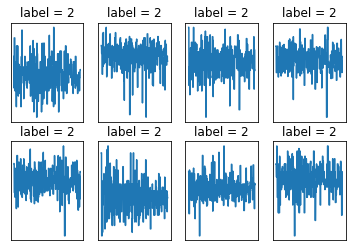

IndexError: index 10 is out of bounds for axis 0 with size 10

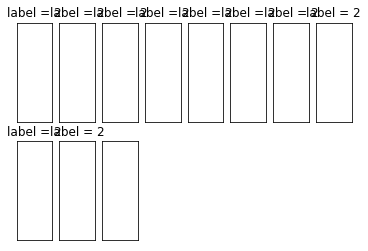

In [1435]:
ind = 2
chind = 2
fig = plt.figure()
for i in range(8):
    fig.add_subplot(2,4,i+1, xticks=[], yticks=[])
    plt.plot(sample0.numpy()[ind][i])
    plt.title(f'label = {label[ind]}')
plt.show()
fig = plt.figure()
for i in range(16):
    fig.add_subplot(2,8,i+1, xticks=[], yticks=[])
    plt.plot(sample1.detach().numpy()[ind][i])
    plt.title(f'label = {label[ind]}')
plt.show()

KeyboardInterrupt: 

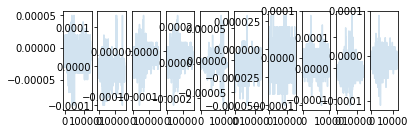

In [974]:
# experiments to see what kind of features the data presents
labels = [1,2,3,4,5,6]
lens=[]
#loop over all possible gestures
for label in labels:
    fig = plt.figure()
    
    # loop over 10 random samples
    for j in range(20):
        
        #load a random sample from the dataset
        sample = load_random_sample(path)
        
        #quick and dirty flags
        flag = 0
        datatmp = 1
        
        #loop over MYO channels
        for i in range(1,9):
            # finds where the first repeat of the gesture (label) ends
            inds = np.hstack(np.where(sample['labels'] == label)[0])
            jumps = np.hstack(np.where(np.diff(inds) > 2)[0])

            if flag: # only the first channel
                datatmp = (sample['channel_' + str(i)][sample['labels'] == label][:jumps[0]].values)
            else:
                data = (sample['channel_' + str(i)][sample['labels'] == label][:jumps[0]].values)
                flag = 1
            # concatenate together each channel in a single timeserie
            if i>1:
                data = np.insert(data,len(data),datatmp)

        ax = fig.add_subplot(2, 20/2, j+1)
        #ax.set_ylim([1,1.005])
        ax.plot(np.arange(len(data)),data,alpha = 0.2)
        lens.append(len(data))

plt.show()

# fro each sample we did the following:
#    - isolated the segments of the signal corresponding to each gesture for each channel
#    - concatenated the isolated segments coming form each channel into a single serie
# from the concatenated series it looks like each gesture presents some "feature".I am going to create a dataset of such concatenated series.

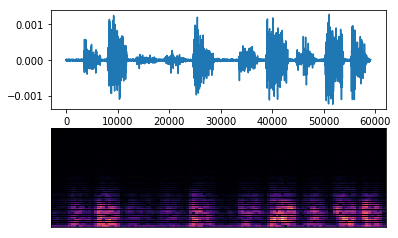

In [786]:
sample = load_random_sample(path)
plt.subplot(211)
plt.plot(scipy.ndimage.gaussian_filter( sample['channel_1'],1))
plt.subplot(212)
S = lb.feature.melspectrogram(scipy.ndimage.gaussian_filter( sample['channel_1'],50),fmax=500)
display.specshow((S**(1/4)))

In [23]:
inds0 = np.where(sample['labels']==0)[0]

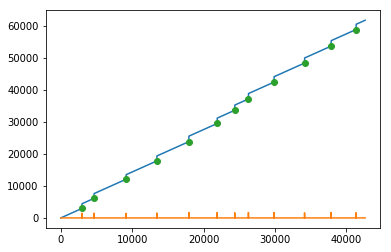

In [37]:
plt.plot(inds0)
plt.plot(np.diff(inds0))
plt.plot(np.hstack(np.where(np.diff(inds0)>2)[0]), np.hstack((inds0[np.where(np.diff(inds0)>2)[0]])),'o')
plt.show()

### experiments on nn structure

In [186]:
import cv2
import torch.nn as nn

In [235]:
m = nn.Conv1d(16, 33, 1, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)

In [228]:
output

tensor([[[-0.3108, -0.3108, -0.3108,  ..., -0.3108, -0.3108, -0.3108]]],
       grad_fn=<SqueezeBackward1>)

In [266]:
inp = torch.FloatTensor(np.array([[data]]))
m = nn.Conv1d(1, 6, 1000, stride=2)
p = nn.MaxPool1d(2,2)
n = nn.Conv1d(6, 16, 1000, stride=2)
q = nn.MaxPool1d(2,2)
output = q(n(p(m(inp))))